In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
from sklearn.metrics import classification_report
import pickle
import shap

# Test already implemented Catboost model 

## Importing Dataset

In [2]:
df = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Delimitate Data

In [3]:
y = df['stroke']
X  = df
X.drop('stroke', axis=1, inplace=True) 
X.drop('id', axis=1, inplace=True) 

Split to train & test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33, random_state=67)
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
1203,Male,21.0,0,0,No,Private,Urban,82.71,20.1,formerly smoked
2100,Female,52.0,0,0,Yes,Private,Urban,93.14,32.5,never smoked
4597,Female,29.0,0,0,Yes,Private,Rural,108.14,25.1,formerly smoked
4315,Female,28.0,0,0,Yes,Private,Urban,100.80,39.3,formerly smoked
752,Female,78.0,0,0,No,Private,Urban,103.86,30.6,Unknown


Features

In [5]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type',
            'smoking_status']

categorical_features_num = [0, 4, 5, 6, 9]

In [6]:
with open ('testX.pickle', 'rb') as f:
    data = pickle.load(f)

with open ('preprocessors_catboost.pickle', 'rb') as f:
    preprrocessor_test = pickle.load(f)

with open("hypertuned-catboost.pickle", "rb") as f:
    model = pickle.load(f)

for p in preprrocessor_test:
    print(p.transform(data[numerical_features]))
    data[numerical_features] = p.transform(data[numerical_features])

data

[[22. 22. 22.]]
[[-0.9321561  -1.88029835 -0.86801265]]


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,-0.932156,1,1,Yes,Private,Urban,-1.880298,-0.868013,never smoked


In [7]:
old_X_test = X_test.copy()

In [8]:
data_use = X_test.iloc[5:6]
data_use

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
1536,Female,13.0,0,0,No,children,Rural,93.3,25.9,Unknown


In [9]:
with open ("explainer.pickle", "rb") as f:
    shap_explainer = pickle.load(f)


shap_values = shap_explainer(data_use)

result = model.predict(data_use)
probability = model.predict_proba(data_use)

df = pd.DataFrame(shap_values.values, columns=X_test.columns)
sorted_columns = (df.abs().mean().sort_values(ascending=False).index)
df_sorted = df[sorted_columns]
to_print = df_sorted.copy()
df_sorted['result'] = result[0]
df_sorted['probability_no_stroke'] = probability[0][0]
df_sorted['probability_stroke'] = probability[0][1]
df_sorted

/Users/patrickknab/opt/anaconda3/envs/ML/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/patrickknab/opt/anaconda3/envs/ML/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def d

,age,avg_glucose_level,work_type,Residence_type,bmi,ever_married,hypertension,smoking_status,gender,heart_disease,result,probability_no_stroke,probability_stroke
0,1.85298,0.841672,-0.600837,-0.165313,0.135603,-0.129915,-0.054152,-0.037109,-0.022866,-0.012415,0,0.845955,0.154045


<AxesSubplot:>

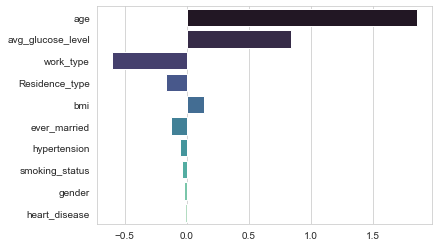

In [10]:
sns.set_style("whitegrid")

sns.barplot(data=to_print, orient = 'h', palette = "mako")

In [11]:
model.predict(X_test).argmax()

iteritems is deprecated and will be removed in a future version. Use .items instead.


150

In [12]:
model.predict_proba(X_test.iloc[150])

array([0.49787814, 0.50212186])

In [14]:
shap_values
df = pd.DataFrame(shap_values.values, columns=data.columns)
sorted_columns = df.abs().mean().sort_values(ascending=False).index

df_sorted = df[sorted_columns]
df_sorted.head()

,hypertension,age,bmi,Residence_type,gender,work_type,heart_disease,ever_married,smoking_status,avg_glucose_level
0,1.070758,-0.98194,-0.766197,0.203072,-0.190963,0.175091,0.162119,0.114387,0.054924,-0.05428


In [15]:
preprocessors = [SimpleImputer(strategy='mean'), StandardScaler()]

preprocessor_list = []

for p in preprocessors:
    p = p.fit(X_train[numerical_features])
    X_train[numerical_features] = p.transform(X_train[numerical_features])
    X_test[numerical_features] = p.transform(X_test[numerical_features])

with open ('preprocessors_catboost.pickle', 'wb') as f:
    pickle.dump(preprocessors, f)

# Train new Catboost model

## Preprocessing

In [18]:
preprocessors = [SimpleImputer(strategy='mean'), StandardScaler()]

for p in preprocessors:
    X_train[numerical_features] = p.fit_transform(X_train[numerical_features])
    X_test[numerical_features] = p.transform(X_test[numerical_features])

with open ("preprocessors.pickle", "wb") as f:
    pickle.dump(preprocessors, f)

oversample = SMOTENC(categorical_features_num) 
X_train, y_train = oversample.fit_resample(X_train, y_train)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [19]:
X_train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,-0.976625,0,0,No,Private,Urban,-0.496663,-1.112250,formerly smoked
1,Female,0.401910,0,0,Yes,Private,Urban,-0.258954,0.481721,never smoked
2,Female,-0.620874,0,0,Yes,Private,Rural,0.082910,-0.469520,formerly smoked
3,Female,-0.665343,0,0,Yes,Private,Urban,-0.084376,1.355834,formerly smoked
4,Female,1.558101,0,0,No,Private,Urban,-0.014636,0.237483,Unknown
...,...,...,...,...,...,...,...,...,...,...
3207,Female,0.080081,0,0,Yes,Private,Urban,-0.604700,-0.045887,formerly smoked
3208,Female,0.830673,0,1,Yes,Private,Urban,2.374447,-0.004667,smokes
3209,Female,1.596174,0,0,Yes,Private,Urban,2.819734,0.180868,never smoked
3210,Female,0.998699,0,0,Yes,Private,Urban,-0.075770,-0.041169,Unknown


Hypertuning: Optuna framework

In [22]:
!pip install optuna


[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


Model Evaluation: before hypertuning

In [23]:
cat_model = CatBoostClassifier(task_type='CPU', 
                               iterations=1000, 
                               random_state=67, 
                               eval_metric="Precision", 
                               class_weights = {0:0.08457286432160804, 1: 0.915427135678392},
                               learning_rate = 0.1
                               )
cat_model.fit(X_train, y_train, cat_features = categorical_features, plot=True, eval_set=(X_test, y_test))


iteritems is deprecated and will be removed in a future version. Use .items instead.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9515273	test: 0.4804475	best: 0.4804475 (0)	total: 13.2ms	remaining: 13.2s
1:	learn: 0.9593566	test: 0.5259399	best: 0.5259399 (1)	total: 21.2ms	remaining: 10.6s
2:	learn: 0.9595156	test: 0.5265520	best: 0.5265520 (2)	total: 25.9ms	remaining: 8.61s
3:	learn: 0.9602581	test: 0.5294658	best: 0.5294658 (3)	total: 31ms	remaining: 7.73s
4:	learn: 0.9603642	test: 0.5304004	best: 0.5304004 (4)	total: 38.1ms	remaining: 7.58s
5:	learn: 0.9606297	test: 0.5332479	best: 0.5332479 (5)	total: 43.1ms	remaining: 7.14s
6:	learn: 0.9613740	test: 0.5288093	best: 0.5332479 (5)	total: 46.4ms	remaining: 6.58s
7:	learn: 0.9615336	test: 0.5286990	best: 0.5332479 (5)	total: 52.2ms	remaining: 6.48s
8:	learn: 0.9618530	test: 0.5275046	best: 0.5332479 (5)	total: 57.7ms	remaining: 6.35s
9:	learn: 0.9617998	test: 0.5273344	best: 0.5332479 (5)	total: 69.9ms	remaining: 6.92s
10:	learn: 0.9626525	test: 0.5270924	best: 0.5332479 (5)	total: 74.7ms	remaining: 6.71s
11:	learn: 0.9630794	test: 0.5305604	best: 0

In [24]:
y_pred = cat_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      3255
           1       0.13      0.45      0.20       169

    accuracy                           0.82      3424
   macro avg       0.55      0.64      0.55      3424
weighted avg       0.93      0.82      0.86      3424

F1 Score: 0.19765929778933683
Accuracy: 0.8198014018691588
Precision: 0.12666666666666668
Recall: 0.44970414201183434


Find best hyperparameters

In [25]:
def objective(trial):

    model = CatBoostClassifier(
        cat_features=categorical_features,
        class_weights = [trial.suggest_float("weight_class_0", 0.1, 1.0),trial.suggest_float("weight_class_1", 0.1, 1.0)],
        task_type=trial.suggest_categorical("task_type", ["CPU"]),
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        eval_metric="Precision",
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    print(f"Trial #{trial.number}: F1={f1}, Acc={acc}, Prec={prec}, Rec={rec}")
    return prec

Create the study

In [29]:
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
try:
    study.optimize(objective, n_trials=10) 
except:
    pass

Custom logger is already specified. Specify more than one logger at same time is not thread safe.iteritems is deprecated and will be removed in a future version. Use .items instead.


Trial #0: F1=0.21766561514195581, Acc=0.7102803738317757, Prec=0.12556869881710647, Rec=0.8165680473372781
Trial #1: F1=0.17821782178217824, Acc=0.9030373831775701, Prec=0.15319148936170213, Rec=0.21301775147928995


iteritems is deprecated and will be removed in a future version. Use .items instead.


Trial #2: F1=0.18633540372670807, Acc=0.8469626168224299, Prec=0.12631578947368421, Rec=0.35502958579881655


iteritems is deprecated and will be removed in a future version. Use .items instead.


Trial #3: F1=0.18069815195071867, Acc=0.8834696261682243, Prec=0.13836477987421383, Rec=0.2603550295857988


iteritems is deprecated and will be removed in a future version. Use .items instead.


Trial #4: F1=0.21902017291066284, Acc=0.7625584112149533, Prec=0.13073394495412843, Rec=0.6745562130177515


iteritems is deprecated and will be removed in a future version. Use .items instead.


Trial #5: F1=0.2059447983014862, Acc=0.7815420560747663, Prec=0.12548512289780078, Rec=0.5739644970414202


iteritems is deprecated and will be removed in a future version. Use .items instead.


Trial #6: F1=0.1969111969111969, Acc=0.8785046728971962, Prec=0.14613180515759314, Rec=0.30177514792899407


iteritems is deprecated and will be removed in a future version. Use .items instead.


Trial #7: F1=0.1698841698841699, Acc=0.8744158878504673, Prec=0.12607449856733524, Rec=0.2603550295857988


iteritems is deprecated and will be removed in a future version. Use .items instead.


Trial #8: F1=0.19455252918287938, Acc=0.8790887850467289, Prec=0.14492753623188406, Rec=0.2958579881656805


iteritems is deprecated and will be removed in a future version. Use .items instead.


Trial #9: F1=0.15686274509803919, Acc=0.8995327102803738, Prec=0.13389121338912133, Rec=0.1893491124260355


Evaluate trial

In [30]:
if len(study.trials) > 0:
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
else:
    print("No trials completed yet.")

Best trial:
  Value:  0.15319148936170213
  Params: 
    weight_class_0: 0.7166975503570835
    weight_class_1: 0.2840070247583657
    task_type: CPU
    iterations: 891
    learning_rate: 0.0011344234265835236
    depth: 8
    l2_leaf_reg: 0.00014895257782642692
    bootstrap_type: Bayesian
    random_strength: 0.0010671081971401395
    bagging_temperature: 1.4038693859523377
    od_type: Iter
    od_wait: 49


In [31]:
print(trial.params)


weight_0 = trial.params['weight_class_0']
weight_1 = trial.params['weight_class_1']

del trial.params['weight_class_0']
del trial.params['weight_class_1']


{'weight_class_0': 0.7166975503570835, 'weight_class_1': 0.2840070247583657, 'task_type': 'CPU', 'iterations': 891, 'learning_rate': 0.0011344234265835236, 'depth': 8, 'l2_leaf_reg': 0.00014895257782642692, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0010671081971401395, 'bagging_temperature': 1.4038693859523377, 'od_type': 'Iter', 'od_wait': 49}


Hypertuned fitting of the model

In [32]:
model = CatBoostClassifier(**trial.params, verbose=False, eval_metric="Precision", cat_features = categorical_features, class_weights = {0:weight_0, 1: weight_1},)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

iteritems is deprecated and will be removed in a future version. Use .items instead.



Final results

In [33]:
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3255
           1       0.15      0.21      0.18       169

    accuracy                           0.90      3424
   macro avg       0.56      0.58      0.56      3424
weighted avg       0.92      0.90      0.91      3424

F1 Score: 0.17821782178217824
Accuracy: 0.9030373831775701
Precision: 0.15319148936170213
Recall: 0.21301775147928995


In [34]:
with open("hypertuned-catboost.pickle", "rb") as f:
    model = pickle.load(f)
    

In [35]:
model.predict(X_test)

iteritems is deprecated and will be removed in a future version. Use .items instead.


array([0, 0, 0, ..., 0, 0, 0])